In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import datetime as dt

warnings.simplefilter(action='ignore', category=Warning)

from funcs.data_prep import *
from funcs.eda import *

C:\Users\btskd\anaconda3\envs\for_clust\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Veri Setinin Yüklenmesi

In [2]:
df = pd.read_excel("../datasets/online_retail_II.xlsx")

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

Veri setinin bir kopyasını oluşturup eksik verileri siliyoruz. Ayrıca bazı faturaların başında C ifadesi yer almakta. Bu o siparişin iptal edildiği anlamına gelir. İade edilen siparişleri de veri setinden çıkarıyoruz.

In [5]:
df_copy = df.dropna()

In [6]:
df_copy = df_copy[~df_copy["Invoice"].str.contains("C",na=False)]

In [7]:
df_copy.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [8]:
df_copy = df_copy.reset_index()

In [9]:
df_copy.drop("index", axis=1, inplace=True)

In [10]:
df_copy.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [11]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407695 entries, 0 to 407694
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      407695 non-null  object        
 1   StockCode    407695 non-null  object        
 2   Description  407695 non-null  object        
 3   Quantity     407695 non-null  int64         
 4   InvoiceDate  407695 non-null  datetime64[ns]
 5   Price        407695 non-null  float64       
 6   Customer ID  407695 non-null  float64       
 7   Country      407695 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.9+ MB


Veri setinde aynı müşterinin birden fazla işlemi olduğu için toplam müşteri sayısını öğrenmek zor. Dolayısıyla "Country" ve "Customer ID" değişkenlerinden farklı bir df oluşturup ID ve ülke bilgisinin sadece bir kere yazılmasını sağlarsak ülkelere göre müşteri sayısını gözlemleyebiliriz.

In [12]:
filtered_df=df_copy[['Country','Customer ID']].drop_duplicates()

In [13]:
filtered_df.head()

,Country,Customer ID
0,United Kingdom,13085.0
12,United Kingdom,13078.0
31,United Kingdom,15362.0
54,United Kingdom,18102.0
71,France,12682.0


<AxesSubplot:>

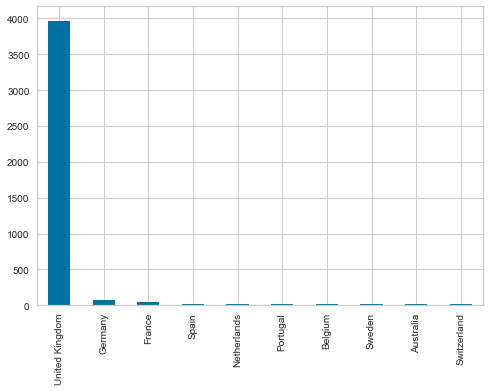

In [14]:
filtered_df["Country"].value_counts()[0:10].plot(kind='bar')

En fazla müşteri United Kingdom'daymış. Diğer ülkelerin müşteri sayıları görece çok az olduğundan dolayı sadece United Kingdom müşterileri üzerinden işlem yapacağız.

In [15]:
uk_data = df_copy[df_copy["Country"] == 'United Kingdom']

In [16]:
uk_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [17]:
uk_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,370951.0,11.994444,67.394793,1.0,2.00,4.00,12.00,10000.0
Price,370951.0,3.145220,30.551482,0.0,1.25,1.95,3.75,10953.5
Customer ID,370951.0,15565.407693,1593.187209,12346.0,14215.00,15601.00,16940.00,18287.0


Quantity değişkeninde 0'dan küçük değerler var. Bu değerleri hatalı olarak kabul edeceğiz. Dolayısıyla veri setimizden çıkarıyoruz.

In [18]:
uk_data = uk_data[(uk_data['Quantity'] > 0)]

In [19]:
uk_data = uk_data[(uk_data['Price'] > 0)]

In [20]:
uk_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,370929.0,11.993058,67.388673,1.000,2.00,4.00,12.00,10000.0
Price,370929.0,3.145406,30.552378,0.001,1.25,1.95,3.75,10953.5
Customer ID,370929.0,15565.454823,1593.169081,12346.000,14215.00,15601.00,16941.00,18287.0


In [21]:
uk_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


RFM analizi yapabilmemiz için gerekli olan değişkenleri bir df içerisine alıyoruz.

In [22]:
uk_data_copy = uk_data[['Customer ID','InvoiceDate','Invoice','Quantity','Price']]

In [23]:
uk_data_copy.head()

,Customer ID,InvoiceDate,Invoice,Quantity,Price
0,13085.0,2009-12-01 07:45:00,489434,12,6.95
1,13085.0,2009-12-01 07:45:00,489434,12,6.75
2,13085.0,2009-12-01 07:45:00,489434,12,6.75
3,13085.0,2009-12-01 07:45:00,489434,48,2.10
4,13085.0,2009-12-01 07:45:00,489434,24,1.25


Müşterinin ilgili ürüne toplam harcadığı tutar:

In [24]:
# ilgili ürün için toplam harcanan miktar
uk_data_copy['TotalPrice'] = uk_data_copy['Quantity'] * uk_data_copy['Price']

In [25]:
uk_data_copy.head()

,Customer ID,InvoiceDate,Invoice,Quantity,Price,TotalPrice
0,13085.0,2009-12-01 07:45:00,489434,12,6.95,83.4
1,13085.0,2009-12-01 07:45:00,489434,12,6.75,81.0
2,13085.0,2009-12-01 07:45:00,489434,12,6.75,81.0
3,13085.0,2009-12-01 07:45:00,489434,48,2.10,100.8
4,13085.0,2009-12-01 07:45:00,489434,24,1.25,30.0


Veri setinde yapılan ilk alışverişin ve son alışverişin tarihleri. Son tarihten bir gün sonrasını şu anki tarih olarak varsayacağız.

In [26]:
# yapılan ilk alışveriş ve yapılan son alışveriş tarihleri
uk_data_copy['InvoiceDate'].min(),uk_data_copy['InvoiceDate'].max()

(Timestamp('2009-12-01 07:45:00'), Timestamp('2010-12-09 20:01:00'))

In [27]:
# son alışveriş yapılan tarihten 1 gün sonrasını şu an ki gün olarak varsayıyoruz
PRESENT = dt.datetime(2010,12,11)

uk_data_copy['InvoiceDate'] = pd.to_datetime(uk_data_copy['InvoiceDate'])

In [28]:
uk_data_copy.head()

,Customer ID,InvoiceDate,Invoice,Quantity,Price,TotalPrice
0,13085.0,2009-12-01 07:45:00,489434,12,6.95,83.4
1,13085.0,2009-12-01 07:45:00,489434,12,6.75,81.0
2,13085.0,2009-12-01 07:45:00,489434,12,6.75,81.0
3,13085.0,2009-12-01 07:45:00,489434,48,2.10,100.8
4,13085.0,2009-12-01 07:45:00,489434,24,1.25,30.0


In [29]:
uk_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370929 entries, 0 to 407694
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Customer ID  370929 non-null  float64       
 1   InvoiceDate  370929 non-null  datetime64[ns]
 2   Invoice      370929 non-null  object        
 3   Quantity     370929 non-null  int64         
 4   Price        370929 non-null  float64       
 5   TotalPrice   370929 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 19.8+ MB


# RFM Analysis

RFM analizi için; recency, frequency ve monetary değerlerini hesaplamamız gerekiyor. Bunları bir değişken olarak ayrı bir veri setinde tutacağız.

In [30]:
rfm= uk_data_copy.groupby('Customer ID').agg({'InvoiceDate': lambda date: (PRESENT - date.max()).days,
                                        'Invoice': lambda num: len(num),
                                        'TotalPrice': lambda price: price.sum()})

In [31]:
rfm.head()

,InvoiceDate,Invoice,TotalPrice
Customer ID,,,
12346.0,165,33,372.86
12608.0,40,16,415.79
12745.0,122,22,723.85
12746.0,176,17,254.55
12747.0,5,154,5080.53


In [32]:
rfm.columns

Index(['InvoiceDate', 'Invoice', 'TotalPrice'], dtype='object')

Değişken isimlerini daha kolay okunması açısından aşağıdaki isimlerle değiştiriyoruz.

In [33]:
# Change the name of columns
rfm.columns=['recency','frequency','monetary']

In [34]:
rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.0,165,33,372.86
12608.0,40,16,415.79
12745.0,122,22,723.85
12746.0,176,17,254.55
12747.0,5,154,5080.53


Recency değişkeni float tipinde, bunu int tipine dönüştürüyoruz.

In [35]:
rfm['monetary'] = rfm['monetary'].astype(int)

In [36]:
rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.0,165,33,372
12608.0,40,16,415
12745.0,122,22,723
12746.0,176,17,254
12747.0,5,154,5080


### Computing Quantile of RFM values

Müşterilerin monetary, frequency ve recency skorlandırmasını yapacağız. (5 eşit parça)

In [37]:
rfm['Recency_score'] = pd.qcut(rfm['recency'], 5, ['5','4','3','2','1'])
rfm['Frequency_score'] = pd.qcut(rfm['frequency'], 5, ['1','2','3','4','5'])
rfm['Monetary_score'] = pd.qcut(rfm['monetary'], 5, ['1','2','3','4','5'])

In [38]:
rfm.head()

,recency,frequency,monetary,Recency_score,Frequency_score,Monetary_score
Customer ID,,,,,,
12346.0,165,33,372,2,3,2
12608.0,40,16,415,3,2,2
12745.0,122,22,723,2,2,3
12746.0,176,17,254,2,2,2
12747.0,5,154,5080,5,5,5


### RFM Result Interpretation


In [39]:
rfm["RFM_SCORE"] = (rfm['Recency_score'].astype(str) + rfm['Frequency_score'].astype(str) + rfm['Monetary_score'].astype(str))

In [40]:
rfm.head()

,recency,frequency,monetary,Recency_score,Frequency_score,Monetary_score,RFM_SCORE
Customer ID,,,,,,,
12346.0,165,33,372,2,3,2,232
12608.0,40,16,415,3,2,2,322
12745.0,122,22,723,2,2,3,223
12746.0,176,17,254,2,2,2,222
12747.0,5,154,5080,5,5,5,555


Yukarıda oluşturduğumuz RFM scorelarına göre müşteri segmentlerini oluşturuyoruz.

In [41]:
#rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

In [42]:
#rfm.drop("segment", axis=1, inplace=True)

In [43]:
#rfm.head()

# Model

In [44]:
kmeans = KMeans(random_state=17)
ssd = [] # sum of squared distances

In [45]:
K = range(1, 30) # cluster parametremizin 1den 30a kadar değer alabilmesi için liste

In [46]:
for k in K: # K içerisindeki değerlerden tek tek yeni modeller oluşturup fit edilecek ve ssd değeri hesaplanıp ssd listesine eklenecek
    kmeans = KMeans(n_clusters=k, random_state=17).fit(rfm)
    ssd.append(kmeans.inertia_)

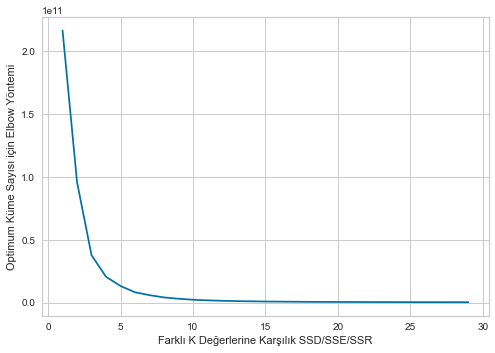

In [47]:
plt.plot(K, ssd, "bx-")
plt.xlabel("Farklı K Değerlerine Karşılık SSD/SSE/SSR")
plt.ylabel("Optimum Küme Sayısı için Elbow Yöntemi")
plt.show()

In [48]:
elbow = KElbowVisualizer(kmeans, k=(2, 20))

In [49]:
#elbow.fit(rfm)
#elbow.show()

In [50]:
# Yukarıdaki valueerror hatasından kurtulmak için aşağıdaki fonksiyonu buldum, veri tiplerini float yapıyor işe yaradı.
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [51]:
rfm_deneme = clean_dataset(rfm)

In [52]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3969 entries, 12346.0 to 18287.0
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   recency          3969 non-null   int64   
 1   frequency        3969 non-null   int64   
 2   monetary         3969 non-null   int32   
 3   Recency_score    3969 non-null   category
 4   Frequency_score  3969 non-null   category
 5   Monetary_score   3969 non-null   category
 6   RFM_SCORE        3969 non-null   object  
dtypes: category(3), int32(1), int64(2), object(1)
memory usage: 151.8+ KB


In [53]:
rfm_deneme.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3969 entries, 12346.0 to 18287.0
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          3969 non-null   float64
 1   frequency        3969 non-null   float64
 2   monetary         3969 non-null   float64
 3   Recency_score    3969 non-null   float64
 4   Frequency_score  3969 non-null   float64
 5   Monetary_score   3969 non-null   float64
 6   RFM_SCORE        3969 non-null   float64
dtypes: float64(7)
memory usage: 248.1 KB


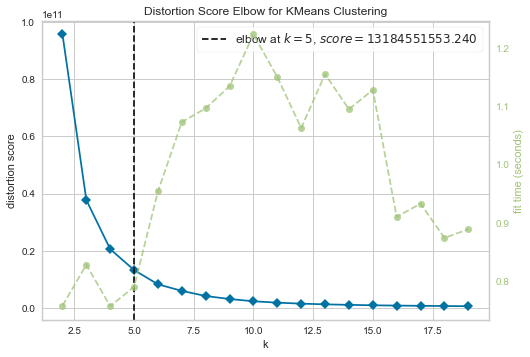

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [54]:
elbow.fit(rfm_deneme)
elbow.show()

Cluster sayımız = 5

In [55]:
elbow.elbow_value_

5

# Final Model

In [56]:
rfm.head()

,recency,frequency,monetary,Recency_score,Frequency_score,Monetary_score,RFM_SCORE
Customer ID,,,,,,,
12346.0,165,33,372,2,3,2,232
12608.0,40,16,415,3,2,2,322
12745.0,122,22,723,2,2,3,223
12746.0,176,17,254,2,2,2,222
12747.0,5,154,5080,5,5,5,555


In [57]:
#rfm_try = rfm.drop(["Recency_score", "Frequency_score", "Monetary_score"], axis=1)

In [58]:
#rfm_try.head()

In [59]:
kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(rfm)

In [60]:
kmeans.cluster_centers_

array([[9.79118388e+01, 6.37128463e+01, 8.79217184e+02, 2.89224741e+00,
        2.81472152e+00, 2.77665827e+00, 3.20148615e+02],
       [1.00000000e+00, 6.27000000e+02, 3.49164000e+05, 5.00000000e+00,
        5.00000000e+00, 5.00000000e+00, 5.55000000e+02],
       [7.16666667e+00, 8.64083333e+02, 6.83600833e+04, 4.91666667e+00,
        4.83333333e+00, 5.00000000e+00, 5.45000000e+02],
       [3.22616279e+01, 2.99813953e+02, 6.28003198e+03, 4.11046512e+00,
        4.61337209e+00, 5.00000000e+00, 4.62180233e+02],
       [1.37179487e+01, 7.47461538e+02, 2.41423333e+04, 4.64102564e+00,
        4.69230769e+00, 5.00000000e+00, 5.16025641e+02]])

In [61]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [62]:
clusters = kmeans.labels_

In [63]:
rfm["cluster"] = clusters

In [64]:
rfm.head()

,recency,frequency,monetary,Recency_score,Frequency_score,Monetary_score,RFM_SCORE,cluster
Customer ID,,,,,,,,
12346.0,165,33,372,2,3,2,232,0
12608.0,40,16,415,3,2,2,322,0
12745.0,122,22,723,2,2,3,223,0
12746.0,176,17,254,2,2,2,222,0
12747.0,5,154,5080,5,5,5,555,3


In [65]:
rfm["cluster"].value_counts()

0    3571
3     346
4      39
2      12
1       1
Name: cluster, dtype: int64

In [96]:
rfm["RFM_SCORE"].unique()

array(['232', '322', '223', '222', '555', '455', '444', '111', '415',
       '544', '211', '355', '143', '244', '313', '445', '433', '121',
       '212', '221', '344', '154', '543', '245', '431', '354', '535',
       '533', '132', '424', '214', '411', '422', '432', '213', '412',
       '312', '333', '134', '423', '414', '343', '545', '435', '115',
       '434', '454', '122', '522', '123', '112', '155', '531', '345',
       '335', '233', '512', '511', '255', '534', '133', '513', '532',
       '311', '323', '413', '224', '144', '321', '124', '443', '131',
       '331', '215', '243', '235', '142', '554', '253', '334', '523',
       '234', '341', '145', '242', '254', '135', '353', '241', '553',
       '342', '231', '325', '441', '324', '332', '225', '442', '524',
       '125', '421', '515', '315', '542', '425', '314', '114', '514',
       '453', '153', '452', '521', '113', '525', '352', '152', '541',
       '141'], dtype=object)

In [67]:
#rfm.groupby("RFM_Score").agg({"cluster": "count"})

In [68]:
final = uk_data_copy.groupby('Customer ID').agg({'InvoiceDate': lambda date: (PRESENT - date.max()).days,
                                        'Invoice': lambda num: len(num),
                                        'TotalPrice': lambda price: price.sum()})

In [69]:
final.head()

,InvoiceDate,Invoice,TotalPrice
Customer ID,,,
12346.0,165,33,372.86
12608.0,40,16,415.79
12745.0,122,22,723.85
12746.0,176,17,254.55
12747.0,5,154,5080.53


In [70]:
final["cluster"] = clusters

In [71]:
final.head()

,InvoiceDate,Invoice,TotalPrice,cluster
Customer ID,,,,
12346.0,165,33,372.86,0
12608.0,40,16,415.79,0
12745.0,122,22,723.85,0
12746.0,176,17,254.55,0
12747.0,5,154,5080.53,3


In [72]:
final["cluster"] = clusters + 1

In [73]:
final.groupby("cluster").agg({"TotalPrice": "sum"}).sort_values("TotalPrice", ascending=False)

,TotalPrice
cluster,
1,3136058.527
4,2167638.493
5,941569.953
3,820324.640
2,349164.350


In [74]:
final.groupby("cluster").agg({"Invoice": "sum"}).sort_values("Invoice", ascending=False)

,Invoice
cluster,
1,226719
4,104063
5,29151
3,10369
2,627


In [75]:
final.groupby("cluster").agg({"InvoiceDate": "mean"}).sort_values("InvoiceDate", ascending=False)

,InvoiceDate
cluster,
1,97.951554
4,32.231214
5,13.717949
3,7.166667
2,1.000000


In [76]:
final.groupby("cluster").agg({"Invoice": "count"}).sort_values("Invoice", ascending=False)

,Invoice
cluster,
1,3571
4,346
5,39
3,12
2,1


In [77]:
final["cluster"].value_counts()

1    3571
4     346
5      39
3      12
2       1
Name: cluster, dtype: int64

In [78]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

In [79]:
rfm.head()

,recency,frequency,monetary,Recency_score,Frequency_score,Monetary_score,RFM_SCORE,cluster
Customer ID,,,,,,,,
12346.0,165,33,372,2,3,2,232,0
12608.0,40,16,415,3,2,2,322,0
12745.0,122,22,723,2,2,3,223,0
12746.0,176,17,254,2,2,2,222,0
12747.0,5,154,5080,5,5,5,555,3


In [98]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

In [99]:
rfm["RF_SCORE"] = (rfm['Recency_score'].astype(str) + rfm['Frequency_score'].astype(str))

In [100]:
rfm.head()

,recency,frequency,monetary,Recency_score,Frequency_score,Monetary_score,RFM_SCORE,cluster,RF_SCORE
Customer ID,,,,,,,,,
12346.0,165,33,372,2,3,2,232,0,23
12608.0,40,16,415,3,2,2,322,0,32
12745.0,122,22,723,2,2,3,223,0,22
12746.0,176,17,254,2,2,2,222,0,22
12747.0,5,154,5080,5,5,5,555,3,55


In [101]:
# RFM skorlarını isimlendirelim
rfm['segment'] = rfm['RF_SCORE'].replace(seg_map, regex=True)

In [102]:
rfm.head()

,recency,frequency,monetary,Recency_score,Frequency_score,Monetary_score,RFM_SCORE,cluster,RF_SCORE,segment
Customer ID,,,,,,,,,,
12346.0,165,33,372,2,3,2,232,0,23,at_Risk
12608.0,40,16,415,3,2,2,322,0,32,about_to_sleep
12745.0,122,22,723,2,2,3,223,0,22,hibernating
12746.0,176,17,254,2,2,2,222,0,22,hibernating
12747.0,5,154,5080,5,5,5,555,3,55,champions


In [109]:
rfm.groupby("segment").agg({"cluster": "count"}).sort_values("cluster", ascending=False)

,cluster
segment,
hibernating,932
loyal_customers,715
champions,590
at_Risk,561
potential_loyalists,472
about_to_sleep,305
need_attention,147
promising,102
cant_loose,89


In [ ]:
rfm["segment"].value_counts()

In [ ]:
rfm["segment"].value_counts().plot(kind="bar")

In [ ]:
rfm[rfm["segment"] == "new_customers"].head()